This is a replication of [Population Based Training of Neural Networks](https://arxiv.org/abs/1711.09846) Figure 2.


Given the objective function: 

$$Q(\theta) = 1.2 - (\theta_0^2 + \theta_1^2)$$

And given the surrogate objective function: 

$$\hat Q(\theta \mid h) = 1.2 - (h_0 \theta_0^2 + h_1 \theta_1^2)$$

The goal is to find parameters $\theta$ that maximize $Q$ but we are only given the surrogate function $\hat Q$.

We'll use gradient descent to minimise $\hat Q(\theta \mid h)$. $h$ are hyperparameters, which can change during optimisation. 

The example uses initial $\theta = [0.9, 0.9]$.

We have two workers that use hyperparameters $h=[1, 0]$ and $h=[0, 1]$.

We know that $Q(\theta)$ has a global maximum of 1.2 at $\theta = [0,0]$


In [2]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

In [62]:
class Worker(object):
    def __init__(self, id, initial_theta, initial_h):
        theta = tf.Variable(initial_theta, name='theta')
        h = tf.Variable(initial_h, name='h', trainable=False)
        objective = 1.2 - tf.reduce_sum(tf.pow(theta, 2))
        surrogate_objective = 1.2 - tf.reduce_sum(tf.pow(h * theta, 2))
        surrogate_loss = -1 * surrogate_objective
        update_op = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(surrogate_loss)
        
        self.id = id
        self.theta = theta
        self.h = h
        self.objective = objective
        self.update_op = update_op
        self.trainable_variables = [theta]
        self._history = {"theta" : [], "h" : [], "score" : []}
        
    def train(self, sess):
        theta, h, objective, _ = sess.run([self.theta, self.h, self.objective, self.update_op])        
        self._history['theta'].append(theta[0])
        self._history['h'].append(h[0])
        self._history['score'].append(objective)
        
    def eval(self, sess):
        return sess.run(self.objective)
    
    def explore(self, sess, sd=0.1):
        noise = np.random.normal(loc=0.0, scale=1.0, size=2) * sd
        noise = np.expand_dims(noise, axis=0)        
        sess.run(tf.assign_add(self.h, noise))
        
    def exploit(self, workers, sess):
        scores = [{'idx':i, 'score': worker.eval(sess)} for i, worker in enumerate(workers)]
        best_score = sorted(scores, key=lambda x: x['score'])[-1]
        
        my = self.trainable_variables
        best = workers[best_score['idx']].trainable_variables
        for my_var, best_var in zip(my, best):
            sess.run(tf.assign(my_var, best_var))
        
    @property
    def history(self):
        return {
            "theta" : np.vstack(self._history['theta']),
            "h"     : np.vstack(self._history['h']),
            "score" : np.array(self._history['score']),
        }        
        
    
def run_experiment(explore=True, exploit=True, explore_exploit_freq=5, nb_steps=500):
    
    tf.reset_default_graph()

    workers = [
        Worker(
            id=1,
            initial_theta=np.array([[0.9, 0.9]]),
            initial_h=np.array([[1.0, 0.0]])
        ),
        Worker(
            id=2,
            initial_theta=np.array([[0.9, 0.9]]), 
            initial_h=np.array([[0.0, 1.0]])
        )
    ]

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for step in range(nb_steps):
            for i, worker in enumerate(workers):            
                if (step + 1) % explore_exploit_freq == 0:
                    if exploit:
                        worker.exploit(workers, sess)
                    if explore:
                        worker.explore(sess)
                worker.train(sess)
    return workers                        

grid = run_experiment(explore=False, exploit=False)
explore_only = run_experiment(explore=True, exploit=False)
exploit_only = run_experiment(explore=False, exploit=True)
pbt = run_experiment(explore=True, exploit=True)


## Plot objective score

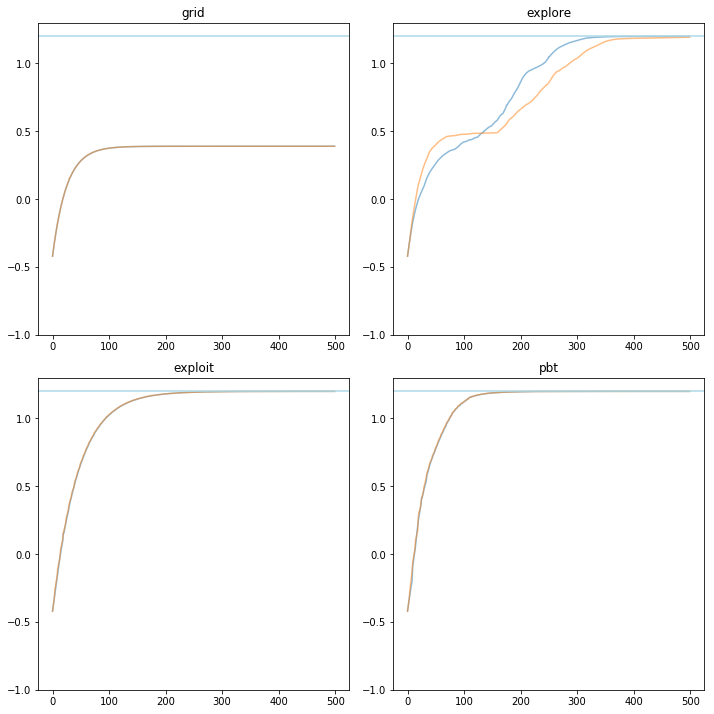

In [83]:
def plot_score(ax, workers, run_name):
    for worker in workers:
        history = worker.history
        ax.plot(history['score'], label="%s worker %d" % (run_name, worker.id), alpha=0.5)
    ax.set_title(run_name)
    ax.set_ylim(-1, 1.3)
    ax.axhline(1.2, c='lightblue')

_, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

plot_score(ax1, grid, 'grid')
plot_score(ax2, explore_only, 'explore only')
plot_score(ax3, exploit_only, 'exploit only')
plot_score(ax4, pbt, 'pbt')
plt.tight_layout(pad=1)
plt.show()

## Plot theta

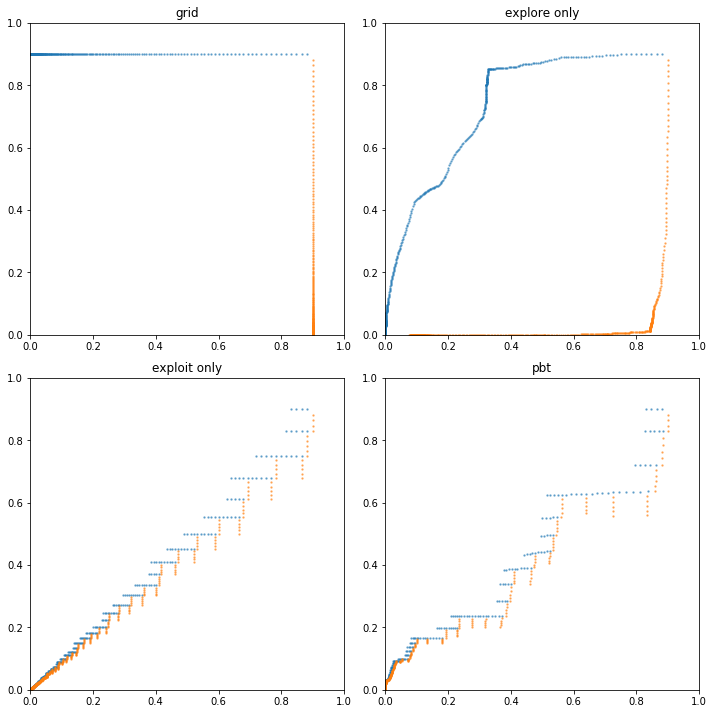

In [86]:
def plot_theta(ax, workers, run_name):
    for worker in workers:
        history = worker.history
        ax.scatter(history['theta'][:,0], history['theta'][:,1], 
                   s=2, alpha=0.5, label="%s worker %d" % (run_name, worker.id))
    ax.set_title(run_name)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

_, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

plot_theta(ax1, grid, 'grid')
plot_theta(ax2, explore_only, 'explore only')
plot_theta(ax3, exploit_only, 'exploit only')
plot_theta(ax4, pbt, 'pbt')
plt.tight_layout(pad=1)
plt.show()